In [1]:
# Imports and Environment Setup

from pathlib import Path
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Environment setup
import dotenv
dotenv.load_dotenv(".env", override=True) # Defines MONGO_URI

# Local
project_root = Path.cwd().parent
src_path = str(project_root / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from analysis.fetch import fetch_images, fetch_chainguard_images, global_latest_scan
from analysis.remediation import fetch_remediations, fetch_chainguard_remediations
from analysis.alpine import list_cgr_alpine
from analysis.stat import RemediationTable
from analysis.plot.hist import rtime_hist
from analysis.plot.timeline import rtime_timeline

In [3]:
# Collect Remediations

CSV_FILE = "remediations.csv"

if not os.path.exists(CSV_FILE):
    tab = fetch_remediations()
    tab._df.to_csv(CSV_FILE, index=False, escapechar="\\")

df = pd.read_csv(CSV_FILE)
df["first_seen_at"] = pd.to_datetime(df["first_seen_at"])
df["remediated_at"] = pd.to_datetime(df["remediated_at"])
tab = RemediationTable(df)

# Filter out Chainguard images based on alpine
OMIT_CSV = "omit.csv"

omit_df = pd.read_csv(OMIT_CSV)
for _, row in omit_df.iterrows():
    tab = tab.filter(repository=row["repository"],
                     purge=True)

print(f"Found {tab._df.shape[0]} scans ending on on {tab.latest_remediation()}")

Found 121303 scans ending on on 2024-07-26 05:01:34.462000


In [17]:
first_detection = tab._df['first_seen_at'].sort_values(ascending=True).iloc[0]
last_remediation = tab._df['remediated_at'].sort_values(ascending=False).iloc[0]
print(f"Gallery detected the first CVE on {first_detection}.")
print(f"The latest remediation was detected on {last_remediation}.")

Gallery detected the first CVE on 2024-03-28 05:00:12.208000.
The latest remediation was detected on 2024-07-26 05:01:34.462000.


In [19]:
"""
Display stats by label

Considers all CVEs seen on day 1 introduced on day 1.
"""

labels = ["docker-official", "ubi", "cgr-public"]
resolved_tab = tab.resolve_edge_cases(remediated_at=False)
resolved_tab = RemediationTable(resolved_tab._df[resolved_tab._df['fix_state'] != 'wont-fix'])
for label in labels:
    label_tab = resolved_tab.filter(label=label)
    n_discovered = label_tab.discovered().shape[0]
    rem_df = label_tab.remediated()
    n_remediated = rem_df.shape[0]
    rtime = rem_df["rtime"].mean()
    rtime_med = rem_df["rtime"].median()
    severe_rtime = rem_df[rem_df["severity"].isin(["critical", "high"])]["rtime"].mean()
    severe_rtime_med = rem_df[rem_df["severity"].isin(["critical", "high"])]["rtime"].median()
    print(label + ":")
    print(f"\tDiscovered: {n_discovered}")
    print(f"\tRemediated: {n_remediated}")
    print(f"\tAverage Remediation time: {rtime / 24:.2f} days") 
    print(f"\tAverage Remediation time (critical + high only): {severe_rtime / 24:.2f} days")
    print(f"\tMedian Remediation time: {rtime_med / 24:.2f} days") 
    print(f"\tMedian Remediation time (critical + high only): {severe_rtime_med / 24:.2f} days")

Resolving edge-cases: 100%|██████████| 121303/121303 [00:10<00:00, 11663.02it/s]


docker-official:
	Discovered: 21883
	Remediated: 16577
	Average Remediation time: 17.50 days
	Average Remediation time (critical + high only): 16.73 days
	Median Remediation time: 10.58 days
	Median Remediation time (critical + high only): 10.58 days
ubi:
	Discovered: 41603
	Remediated: 31337
	Average Remediation time: 17.12 days
	Average Remediation time (critical + high only): 15.80 days
	Median Remediation time: 13.79 days
	Median Remediation time (critical + high only): 9.96 days
cgr-public:
	Discovered: 1272
	Remediated: 1264
	Average Remediation time: 2.67 days
	Average Remediation time (critical + high only): 6.15 days
	Median Remediation time: 1.29 days
	Median Remediation time (critical + high only): 4.00 days


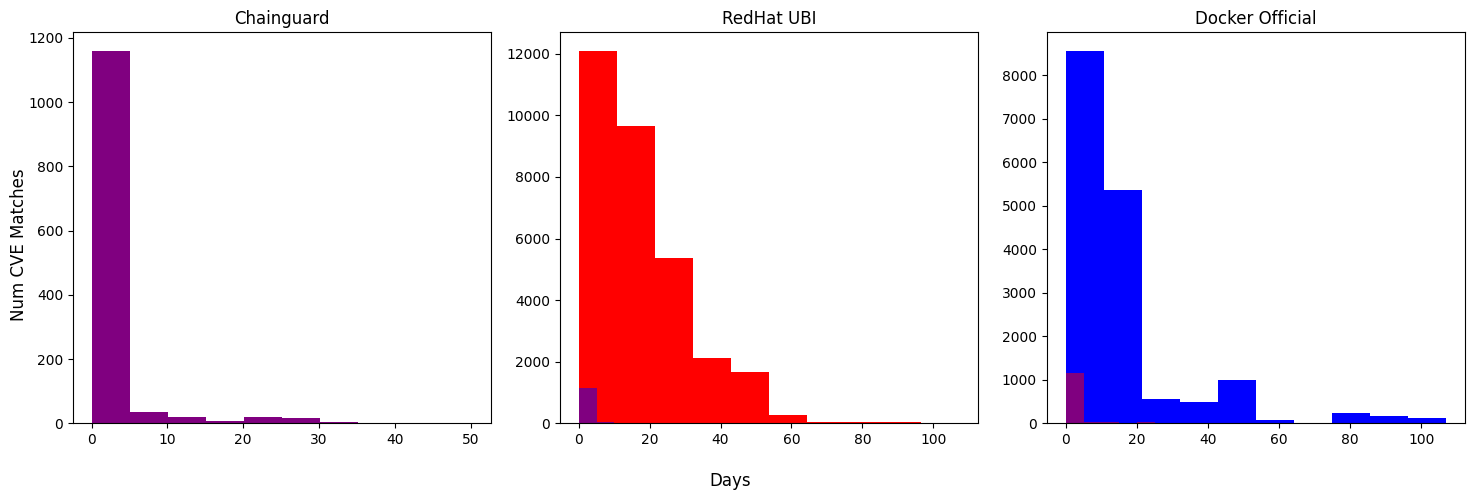

In [4]:
""" Remediation histogram for all matches """

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Chainguard
_tab = resolved_tab.filter(label="cgr-public")
_y = _tab.remediated()["rtime"] / 24
ax[0].hist(_y, color="purple")
ax[0].set_title("Chainguard")

# RHEL
_tab = resolved_tab.filter(label="ubi")
_y = _tab.remediated()["rtime"] / 24
ax[1].hist(_y, color="red")
ax[1].set_title("RedHat UBI")

# Chainguard vs RHEL
_tab = resolved_tab.filter(label="cgr-public")
_y = _tab.remediated()["rtime"] / 24
ax[1].hist(_y, color="purple")

# Docker Official
_tab = resolved_tab.filter(label="docker-official")
_y = _tab.remediated()["rtime"] / 24
ax[2].hist(_y, color="blue")
ax[2].set_title("Docker Official")

# Chainguard vs Docker Official
_tab = resolved_tab.filter(label="cgr-public")
_y = _tab.remediated()["rtime"] / 24
ax[2].hist(_y, color="purple")

# Figure settings
fig.supxlabel("Days")
fig.supylabel("Num CVE Matches")
fig.tight_layout()

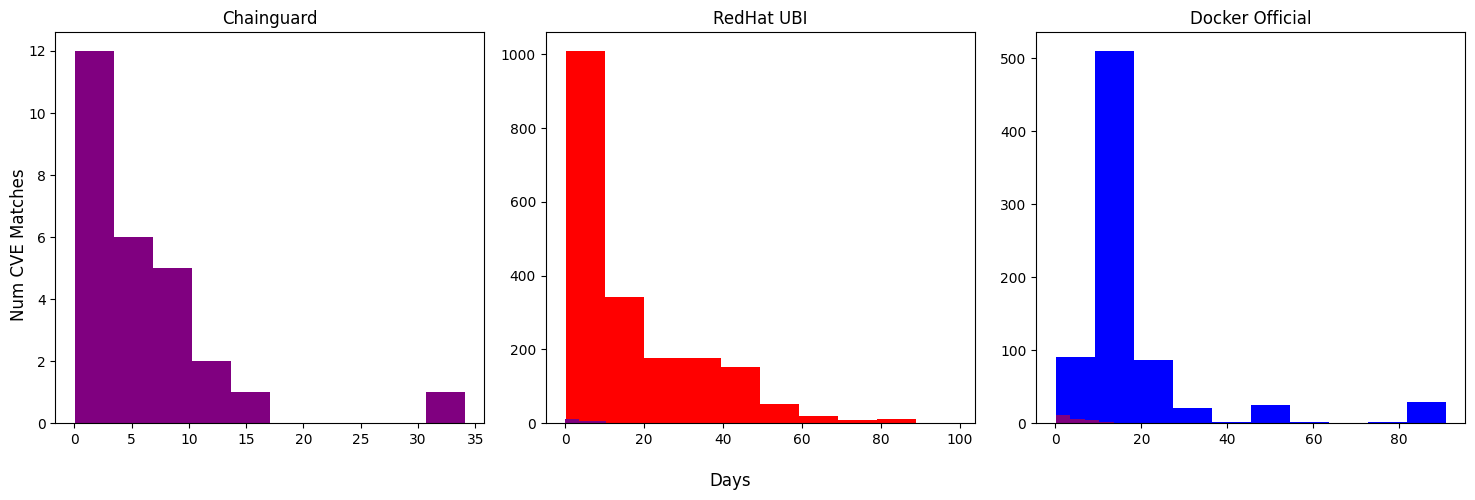

In [5]:
""" Remediation histogram for critical + high matches """

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

severe_resolved_df = resolved_tab._df.copy()
severe_resolved_df = severe_resolved_df[severe_resolved_df["severity"].isin(["critical", "high"])]
severe_resolved_tab = RemediationTable(severe_resolved_df)

# Chainguard
_tab = severe_resolved_tab.filter(label="cgr-public")
_y = _tab.remediated()["rtime"] / 24
ax[0].hist(_y, color="purple")
ax[0].set_title("Chainguard")

# RHEL
_tab = severe_resolved_tab.filter(label="ubi")
_y = _tab.remediated()["rtime"] / 24
ax[1].hist(_y, color="red")
ax[1].set_title("RedHat UBI")

# Chainguard vs RHEL
_tab = severe_resolved_tab.filter(label="cgr-public")
_y = _tab.remediated()["rtime"] / 24
ax[1].hist(_y, color="purple")

# Docker Official
_tab = severe_resolved_tab.filter(label="docker-official")
_y = _tab.remediated()["rtime"] / 24
ax[2].hist(_y, color="blue")
ax[2].set_title("Docker Official")

# Chainguard vs Docker Official
_tab = severe_resolved_tab.filter(label="cgr-public")
_y = _tab.remediated()["rtime"] / 24
ax[2].hist(_y, color="purple")

# Figure settings
fig.supxlabel("Days")
fig.supylabel("Num CVE Matches")
fig.tight_layout()

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

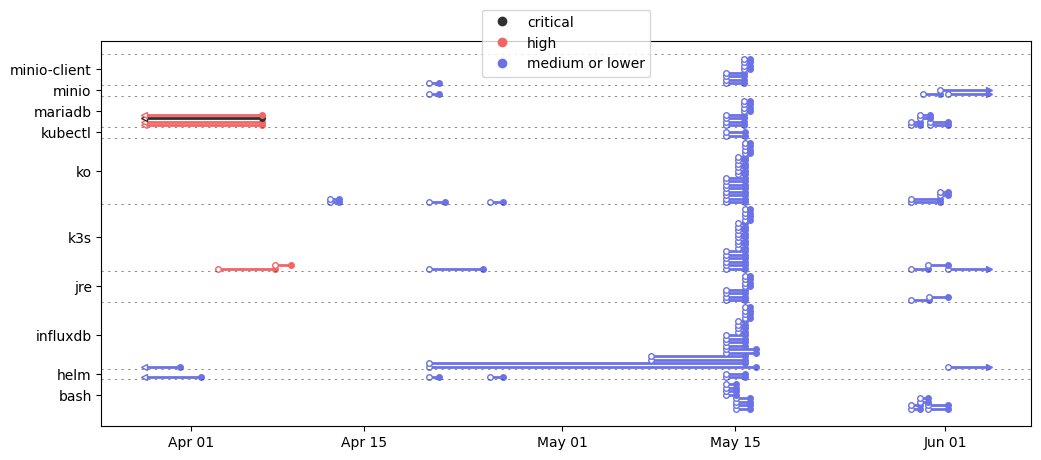

In [12]:
cgr_tab = tab.filter(label="cgr-public")
rtime_timeline(cgr_tab, figsize=(12, 5),
               include_cve_ids=False,
               max_images=10)

keycloak:
    - GHSA-f8h5-v2vg-46rr (CVE-2024-2700)
        > published 15 days ago
        > fixed 6 hours ago